<a href="https://colab.research.google.com/github/csukuangfj/colab/blob/master/vad_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安装 onnxruntime

In [1]:
%%shell

pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.3 MB/s eta 0:00:00


# 下载模型文件

In [2]:
%%shell

wget https://github.com/k2-fsa/sherpa-onnx/releases/download/asr-models/silero_vad_v4.onnx

--2025-09-26 11:12:21--  https://github.com/k2-fsa/sherpa-onnx/releases/download/asr-models/silero_vad_v4.onnx
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/531380835/9e7e1a2c-0003-4ae9-b9b1-69b9498a737e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-26T11%3A51%3A13Z&rscd=attachment%3B+filename%3Dsilero_vad_v4.onnx&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-26T10%3A50%3A19Z&ske=2025-09-26T11%3A51%3A13Z&sks=b&skv=2018-11-09&sig=O7mPQQEqFQo9wxU87nvP72Ni5c3tZddkDEUpAWMm6vA%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODg4NTQ0MSwibmJmIjoxNzU4ODg1MTQxLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjd

# 下载测试音频

In [3]:
%%shell

wget https://github.com/k2-fsa/sherpa-onnx/releases/download/asr-models/test_silero_vad.wav

--2025-09-26 11:12:25--  https://github.com/k2-fsa/sherpa-onnx/releases/download/asr-models/test_silero_vad.wav
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/531380835/9294d5dc-a2e0-4aef-b439-0d2962b2c849?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-26T11%3A49%3A42Z&rscd=attachment%3B+filename%3Dtest_silero_vad.wav&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-26T10%3A49%3A19Z&ske=2025-09-26T11%3A49%3A42Z&sks=b&skv=2018-11-09&sig=qq5zW0CE8yAjcOb9dk0zplgezoUHg641XTC1tORQiRQ%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODg4NTQ0NSwibmJmIjoxNzU4ODg1MTQ1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHV

# 加载模型

In [4]:
import onnxruntime as ort
session_opts = ort.SessionOptions()
session_opts.inter_op_num_threads = 1
session_opts.intra_op_num_threads = 1
model = ort.InferenceSession(
    "./silero_vad_v4.onnx",
    sess_options=session_opts,
    providers=["CPUExecutionProvider"],
)

# 显示模型的输入和输出

In [5]:
for i in model.get_inputs():
    print(i)

print("-----")

for i in model.get_outputs():
    print(i)

NodeArg(name='input', type='tensor(float)', shape=['batch', 'sequence'])
NodeArg(name='sr', type='tensor(int64)', shape=[])
NodeArg(name='h', type='tensor(float)', shape=[2, 'batch', 64])
NodeArg(name='c', type='tensor(float)', shape=[2, 'batch', 64])
-----
NodeArg(name='output', type='tensor(float)', shape=['batch', 1])
NodeArg(name='hn', type='tensor(float)', shape=[2, 'batch', 64])
NodeArg(name='cn', type='tensor(float)', shape=[2, 'batch', 64])


注： 模型内部有两层 LSTM， h, c 为模型输入的状态. hn, cn 为模型输出的状态

# 初始化模型状态

In [6]:
import numpy as np

h = np.zeros((2, 1, 64), dtype=np.float32)
c = np.zeros((2, 1, 64), dtype=np.float32)

# 加载音频文件

In [7]:
import soundfile as sf

def load_audio(filename):
    data, sample_rate = sf.read(
        filename,
        always_2d=True,
        dtype="float32",
    )
    assert sample_rate == 16000, sample_rate

    data = data[:, 0]  # use only the first channel
    samples = np.ascontiguousarray(data)
    return samples

In [8]:
samples = load_audio('./test_silero_vad.wav')

# 运行 vad

In [9]:
def run_model(model, x, h, c):
    """
    Args:
      x: (512,)
      h: (2, 1, 64)
      c: (2, 1, 64)
    Returns:
      prob: (1, 1)
      next_h: (2, 1, 64)
      next_c: (2, 1, 64)
    """
    x = x[None]
    out, next_h, next_c = model.run(
        [
            model.get_outputs()[0].name,
            model.get_outputs()[1].name,
            model.get_outputs()[2].name,
        ],
        {
            model.get_inputs()[0].name: x,
            model.get_inputs()[1].name: np.array(16000, dtype=np.int64),
            model.get_inputs()[2].name: h,
            model.get_inputs()[3].name: c,
        },
    )
    return out, next_h, next_c

In [10]:
probs = []
window_size = 512
num_windows = samples.shape[0] // window_size

for i in range(num_windows):
    start = i * window_size
    end = start + window_size

    p, h, c = run_model(model, samples[start:end], h, c)

    probs.append(p[0].item())

In [11]:
print(probs)
print(len(probs))

[0.09479030966758728, 0.1472407579421997, 0.16740337014198303, 0.27117210626602173, 0.5087785124778748, 0.8915377259254456, 0.9610474109649658, 0.9677715301513672, 0.9683194756507874, 0.9948594570159912, 0.9972723722457886, 0.99692702293396, 0.9961242079734802, 0.9964091777801514, 0.9968227744102478, 0.9915878772735596, 0.9277199506759644, 0.6867348551750183, 0.9505742788314819, 0.9958370923995972, 0.9979422092437744, 0.9982742667198181, 0.9982082843780518, 0.9974868893623352, 0.9965019822120667, 0.994795024394989, 0.994677722454071, 0.9935545325279236, 0.9938145279884338, 0.9931130409240723, 0.9916514754295349, 0.989142656326294, 0.9845834970474243, 0.9695967435836792, 0.996809184551239, 0.9982540607452393, 0.998136579990387, 0.9976637363433838, 0.9736833572387695, 0.7556880712509155, 0.8715656995773315, 0.7378036975860596, 0.9814516305923462, 0.9894236922264099, 0.9833842515945435, 0.9080309867858887, 0.9605156779289246, 0.9939876794815063, 0.9968648552894592, 0.9975143671035767, 0.9

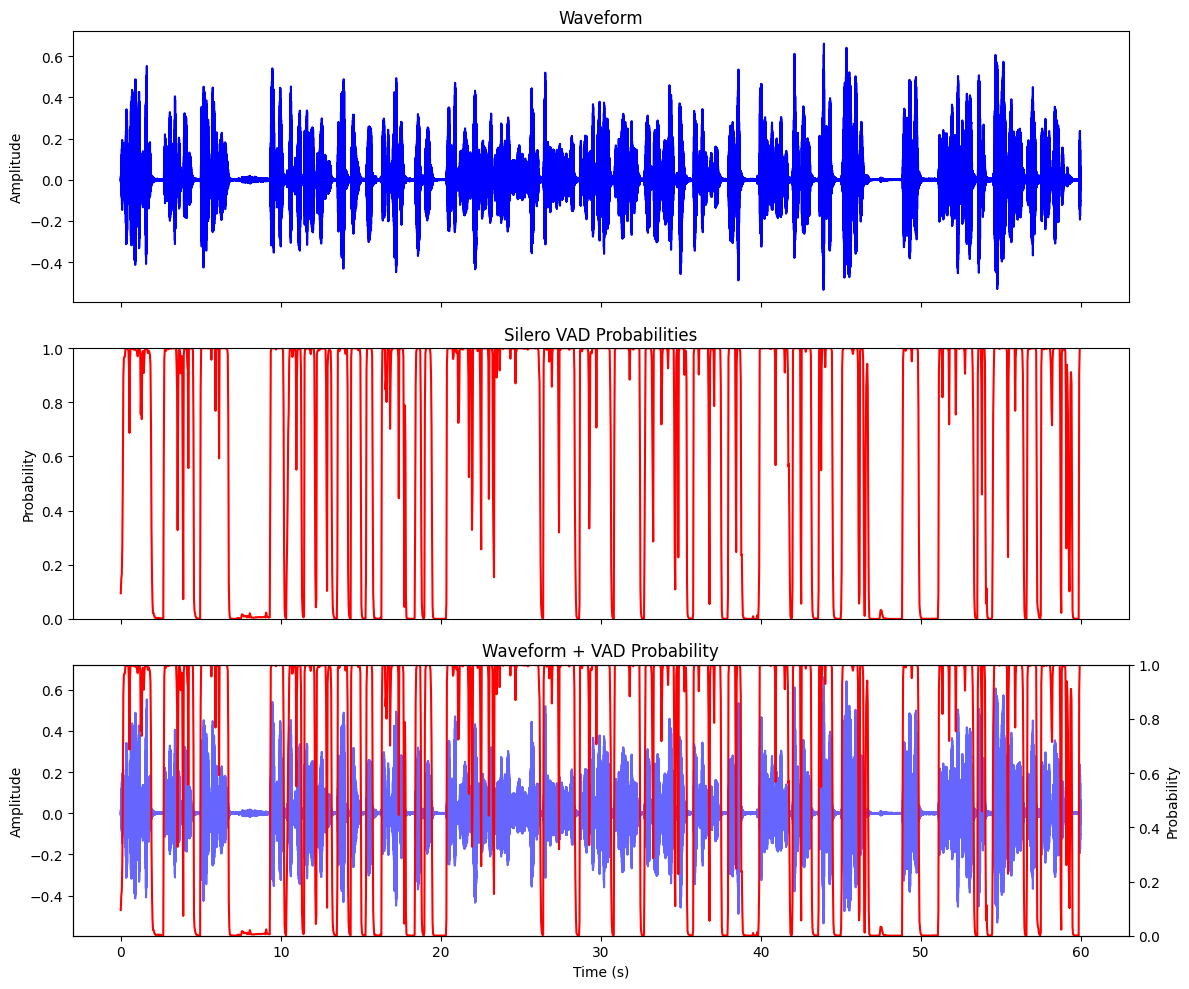

In [12]:
# 如下代码，由 chatgpt 生成

import matplotlib.pyplot as plt

sr = 16000
win_ms = 32

# Time axes
time_audio = np.arange(len(samples)) / sr
time_probs = np.arange(len(probs)) * win_ms / 1000  # in seconds

# ---- Plotting ----
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Waveform
axes[0].plot(time_audio, samples, color="blue")
axes[0].set_title("Waveform")
axes[0].set_ylabel("Amplitude")

# 2. VAD probabilities
axes[1].plot(time_probs, probs, color="red")
axes[1].set_title("Silero VAD Probabilities")
axes[1].set_ylabel("Probability")
axes[1].set_ylim(0, 1)

# 3. Both together
axes[2].plot(time_audio, samples, color="blue", alpha=0.6, label="Waveform")
ax2 = axes[2].twinx()
ax2.plot(time_probs, probs, color="red", label="VAD Probability")
axes[2].set_title("Waveform + VAD Probability")
axes[2].set_ylabel("Amplitude")
ax2.set_ylabel("Probability")
ax2.set_ylim(0, 1)

# Labels
axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [13]:
probs_bak = probs

[0.09479030966758728, 0.1472407579421997, 0.16740337014198303, 0.27117210626602173, 0.5087785124778748, 0.8915377259254456, 0.9610474109649658, 0.9677715301513672, 0.9683194756507874, 0.9948594570159912, 0.9972723722457886, 0.99692702293396, 0.9961242079734802, 0.9964091777801514, 0.9968227744102478, 0.9915878772735596, 0.9277199506759644, 0.6867348551750183, 0.9505742788314819, 0.9958370923995972, 0.9979422092437744, 0.9982742667198181, 0.9982082843780518, 0.9974868893623352, 0.9965019822120667, 0.994795024394989, 0.994677722454071, 0.9935545325279236, 0.9938145279884338, 0.9931130409240723, 0.9916514754295349, 0.989142656326294, 0.9845834970474243, 0.9695967435836792, 0.996809184551239, 0.9982540607452393, 0.998136579990387, 0.9976637363433838, 0.9736833572387695, 0.7556880712509155, 0.8715656995773315, 0.7378036975860596, 0.9814516305923462, 0.9894236922264099, 0.9833842515945435, 0.9080309867858887, 0.9605156779289246, 0.9939876794815063, 0.9968648552894592, 0.9975143671035767, 0.9

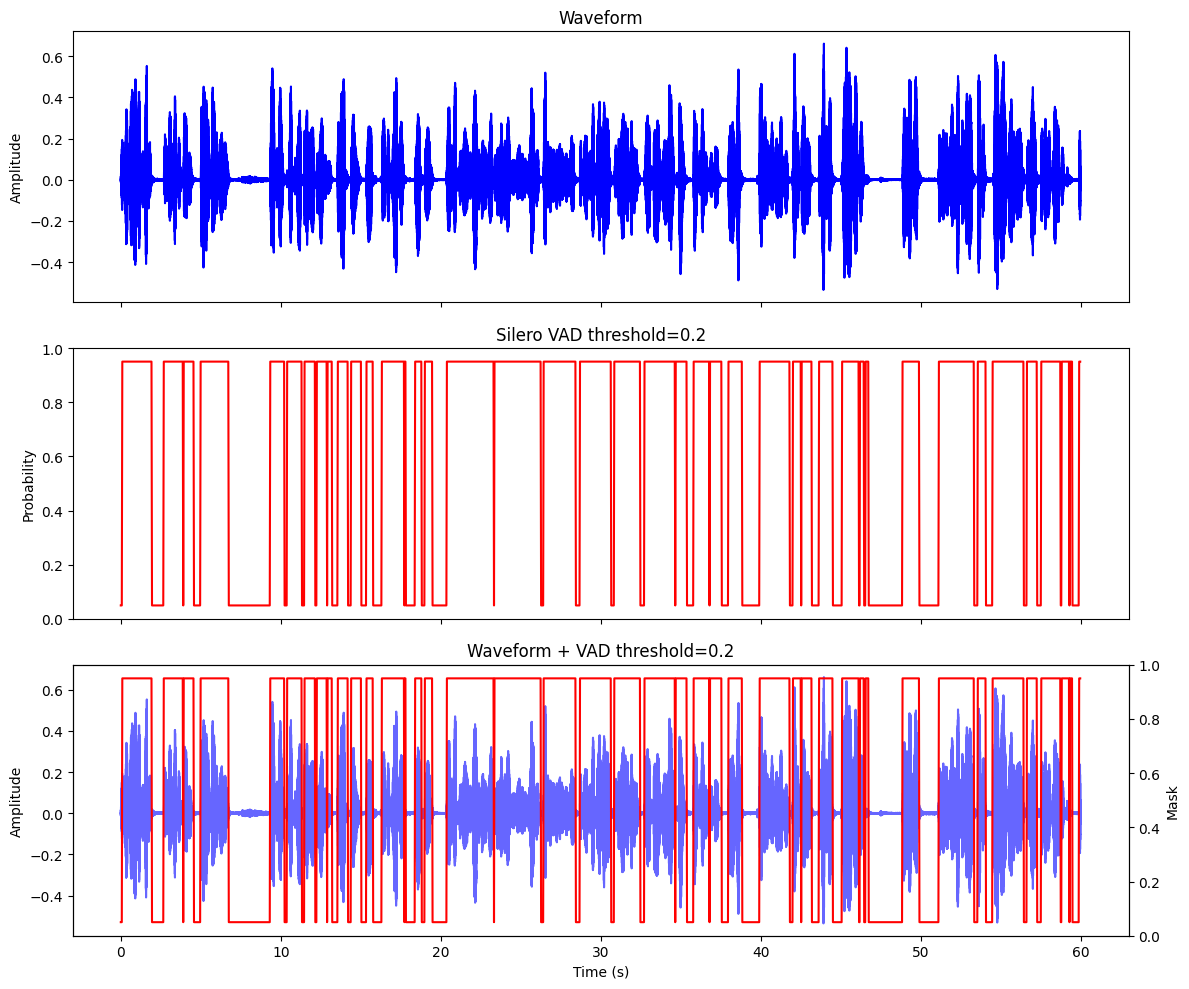

In [14]:
threshold = 0.2
probs = [0.95 if p > threshold else 0.05 for p in probs_bak]
print(probs_bak)
print(probs)

# Time axes
time_audio = np.arange(len(samples)) / sr
time_probs = np.arange(len(probs)) * win_ms / 1000  # in seconds

# ---- Plotting ----
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Waveform
axes[0].plot(time_audio, samples, color="blue")
axes[0].set_title("Waveform")
axes[0].set_ylabel("Amplitude")

# 2. VAD probabilities
axes[1].plot(time_probs, probs, color="red")
axes[1].set_title(f"Silero VAD threshold={threshold}")
axes[1].set_ylabel("Probability")
axes[1].set_ylim(0, 1)

# 3. Both together
axes[2].plot(time_audio, samples, color="blue", alpha=0.6, label="Waveform")
ax2 = axes[2].twinx()
ax2.plot(time_probs, probs, color="red", label=f"VAD threshold={threshold}")
axes[2].set_title(f"Waveform + VAD threshold={threshold}")
axes[2].set_ylabel("Amplitude")
ax2.set_ylabel("Mask")
ax2.set_ylim(0, 1)

# Labels
axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

[0.09479030966758728, 0.1472407579421997, 0.16740337014198303, 0.27117210626602173, 0.5087785124778748, 0.8915377259254456, 0.9610474109649658, 0.9677715301513672, 0.9683194756507874, 0.9948594570159912, 0.9972723722457886, 0.99692702293396, 0.9961242079734802, 0.9964091777801514, 0.9968227744102478, 0.9915878772735596, 0.9277199506759644, 0.6867348551750183, 0.9505742788314819, 0.9958370923995972, 0.9979422092437744, 0.9982742667198181, 0.9982082843780518, 0.9974868893623352, 0.9965019822120667, 0.994795024394989, 0.994677722454071, 0.9935545325279236, 0.9938145279884338, 0.9931130409240723, 0.9916514754295349, 0.989142656326294, 0.9845834970474243, 0.9695967435836792, 0.996809184551239, 0.9982540607452393, 0.998136579990387, 0.9976637363433838, 0.9736833572387695, 0.7556880712509155, 0.8715656995773315, 0.7378036975860596, 0.9814516305923462, 0.9894236922264099, 0.9833842515945435, 0.9080309867858887, 0.9605156779289246, 0.9939876794815063, 0.9968648552894592, 0.9975143671035767, 0.9

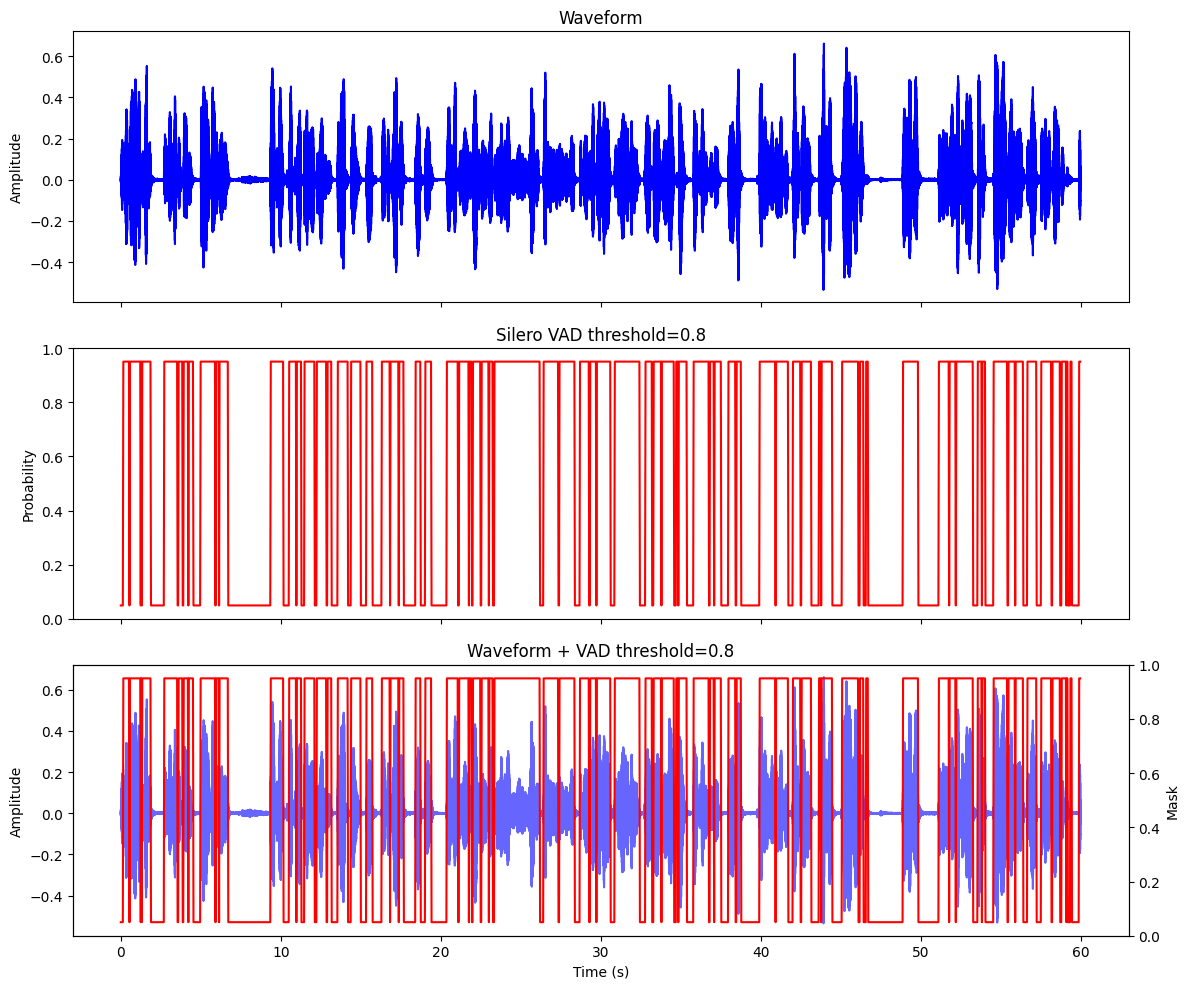

In [15]:

threshold = 0.8
probs = [0.95 if p > threshold else 0.05 for p in probs_bak]
print(probs_bak)
print(probs)

# Time axes
time_audio = np.arange(len(samples)) / sr
time_probs = np.arange(len(probs)) * win_ms / 1000  # in seconds

# ---- Plotting ----
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Waveform
axes[0].plot(time_audio, samples, color="blue")
axes[0].set_title("Waveform")
axes[0].set_ylabel("Amplitude")

# 2. VAD probabilities
axes[1].plot(time_probs, probs, color="red")
axes[1].set_title(f"Silero VAD threshold={threshold}")
axes[1].set_ylabel("Probability")
axes[1].set_ylim(0, 1)

# 3. Both together
axes[2].plot(time_audio, samples, color="blue", alpha=0.6, label="Waveform")
ax2 = axes[2].twinx()
ax2.plot(time_probs, probs, color="red", label=f"VAD threshold={threshold}")
axes[2].set_title(f"Waveform + VAD threshold={threshold}")
axes[2].set_ylabel("Amplitude")
ax2.set_ylabel("Mask")
ax2.set_ylim(0, 1)

# Labels
axes[-1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()